In [1]:
options(repr.plot.width = 10, repr.plot.height = 8)

In [1]:
library(lidR)
library(sf)
library(tidyverse)
library(ggplot2)
library(terra)

Warning message:
"package 'lidR' was built under R version 4.4.2"
Warning message:
"package 'sf' was built under R version 4.4.2"
Linking to GEOS 3.13.0, GDAL 3.10.1, PROJ 9.5.1; sf_use_s2() is TRUE


Attaching package: 'sf'


The following object is masked from 'package:lidR':

    st_concave_hull


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'terra' was built under R version 4.4.2"
terra 1.8.15


Attaching pa

In [ ]:
riesling <- readLAS("../../../data/Georeferenced/CodyKrest9_4_24_riesling_chest1_ref6.las")

## Why is the GPS Time completely off?

In [139]:
gps_time <- as.numeric(riesling@data$gpstime)

In [140]:
gps_epoch <- as.POSIXct("1980-01-06", tz = "UTC")
gps_dates <- gps_epoch + gps_time
head(gps_dates)

[1] "2034-09-09 19:21:17 UTC" "2034-09-09 19:21:17 UTC"
[3] "2034-09-09 19:21:17 UTC" "2034-09-09 19:21:17 UTC"
[5] "2034-09-09 19:21:17 UTC" "2034-09-09 19:21:17 UTC"

## Summary

In [113]:
summary(riesling)

class        : LAS (v1.4 format 7)
memory       : 1.7 Gb 
extent       : 12731583, 12731767, 277534.4, 277855.3 (xmin, xmax, ymin, ymax)
coord. ref.  : NAD83(2011) / Michigan South (ft) 
area         : 34476 ft²
points       : 31.12 million points
density      : 902.57 points/ft²
File signature:           LASF 
File source ID:           0 
Global encoding:
 - GPS Time Type: GPS Week Time 
 - Synthetic Return Numbers: no 
 - Well Know Text: CRS is WKT 
 - Aggregate Model: false 
Project ID - GUID:        00000000-0000-0000-0000-000000000000 
Version:                  1.4
System identifier:        libLAS 
Generating software:      QT Modeler 8.4.1946 
File creation d/y:        9/2025
header size:              375 
Offset to point data:     5431 
Num. var. length record:  1 
Point data format:        7 
Point data record length: 36 
Num. of point records:    31117012 
Num. of points by return: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
Scale factor X Y Z:       1e-04 1e-04 1e-04 
Offset X Y Z:       

In [ ]:
grid_size_ft <- 10 * 3.28084  # 16.4042 feet
density_raster <- grid_density(riesling, res = grid_size_ft)
overall_avg_density <- mean(values(density_raster), na.rm = TRUE)

thinned <- decimate_points(riesling,homogenize(overall_avg_density, res = 1, use_pulse = FALSE))

In [ ]:
writeLAS(thinned, "thinned.las")

In [33]:
# Step 3: Apply the Cloth Simulation Filter (CSF) for ground classification
csf_params <- csf(
  class_threshold = 0.5,  
  cloth_resolution = 1.0,  
  rigidness = 3,          
  time_step = 0.65,        
  iterations = 500       
)

las_ground <- classify_ground(thinned, csf_params)

In [25]:
dem <- rasterize_terrain(las_ground, res = 1, algorithm = tin())

In [35]:
las_ground@data$Classification

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
   [37] 0 2 0 2 0 0 0 0 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
   [73] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 2 2 2 0 0
  [109] 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0
  [145] 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0
  [181] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0
  [217] 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 2 2 2 2 0 2 0 0 0
  [253] 0 2 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 0 0 0 0
  [289] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 2
  [325] 2 2 0 0 0 2 0 0 2 2 0 0 0 2 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 2 2 0 0 0 2
  [361] 0 0 0 0 2 2 2 0 0 2 2 2 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0
  [397] 0 0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 2 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0
  [433] 0 0 2 0 0 0 2 2 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 2 2 2 0 0 2 0 0 2 2 0 2 0
  [469] 0 0 0 0 0 0 0 2 2 0 2 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 2 2 2 0 0 0 0 0 2 0
  [505] 2 0 0 0 2 0 0 0 0 0 2 0 0 2 2 0 0 0 0 0 0 0 0 0 2 2 0 0 0 0 0 0 0 0 2 2
  [541] 2 2 0 0 0 0 2 2 2 2 2 0 0 0 0 2 2 2 2 2 2 2 0 0 0 2 2 2 0 2 0 0 0 0 0 0
  [577] 0 0 0 0 2 2 0 0 2 0 0 0 2 2 0 2 0 2 2 2 0 0 0 0 0 0 0 2 2 0 2 0 0 0 0 0
  [613] 2 2 2 2 2 0 0 2 2 2 2 0 0 0 0 2 2 2 0 0 0 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2
  [649] 2 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 0 2 2 2 0 0 0 2 2 2 2 0 0 0 0 0 0 2 2
  [685] 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 2 2 0 0 0 2 2 2 0 0 0 2 2 2 2 2 2 2 0 0 0
  [721] 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 2 2 2 2 2 2 0 2 0 0 0 0 0
  [757] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 0
  [793] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [829] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [865] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0
  [901] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 2 2 2 2 2 0 0 0 0 0 0 0
  [937] 0 0 0 0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  [973] 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 [1009] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1045] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1081] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1117] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1153] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1189] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1225] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1261] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1297] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1333] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1369] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1405] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1441] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1477] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1513] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1549] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1585] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1621] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1657] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1693] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1729] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [1765] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [18

In [104]:
las_norm <- normalize_height(las_ground, dem)#use_class = las_ground@data$Classification, algorithm = tin()) 

las_filtered <- filter_poi(las_norm, Classification ==0 & Z >= 3 & Z <= 7 )

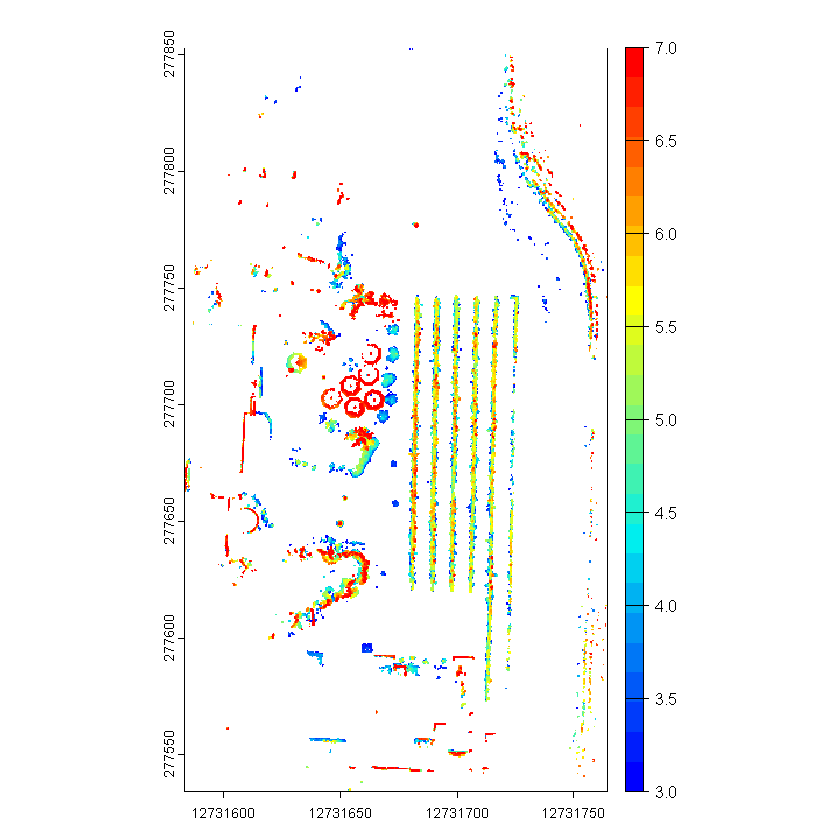

In [74]:
col <- height.colors(25)
plot(cbm, col=col)

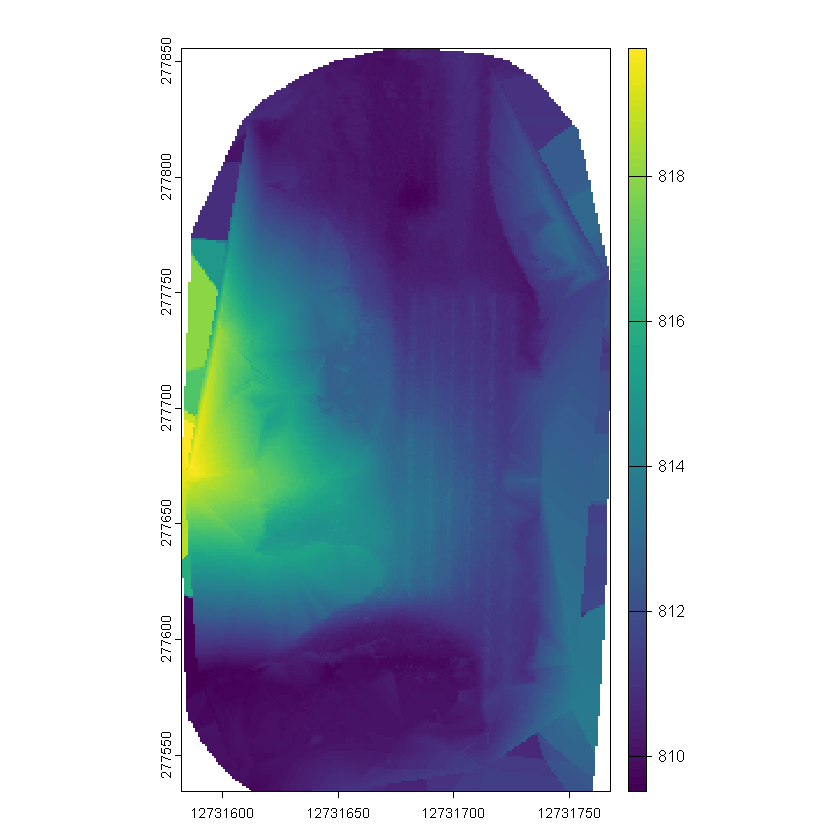

In [40]:
plot(dem)

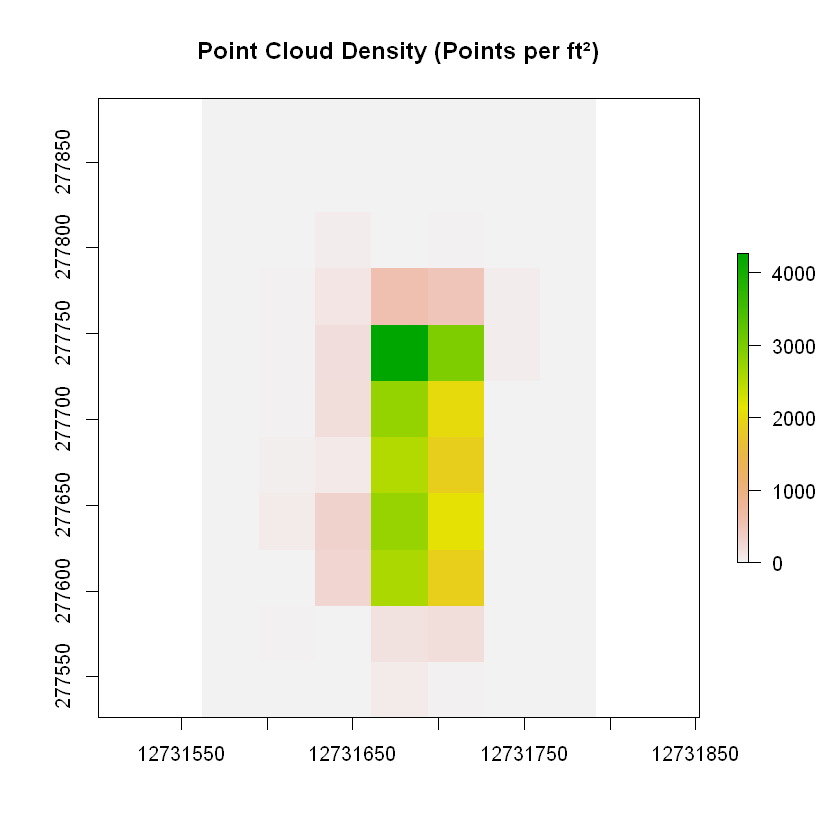

In [28]:
plot(density_raster, main = "Point Cloud Density (Points per ft²)")

In [90]:
st_bbox(las_norm)

      xmin       ymin       xmax       ymax 
12731582.5   277534.4 12731767.5   277855.3 

In [93]:
p1 <- c(12731582.5, 277534.4)  
p2 <- c(12731767.5, 277855.3)
las_tr <- clip_transect(las_norm, p1, p2, width = 5, xz = TRUE)

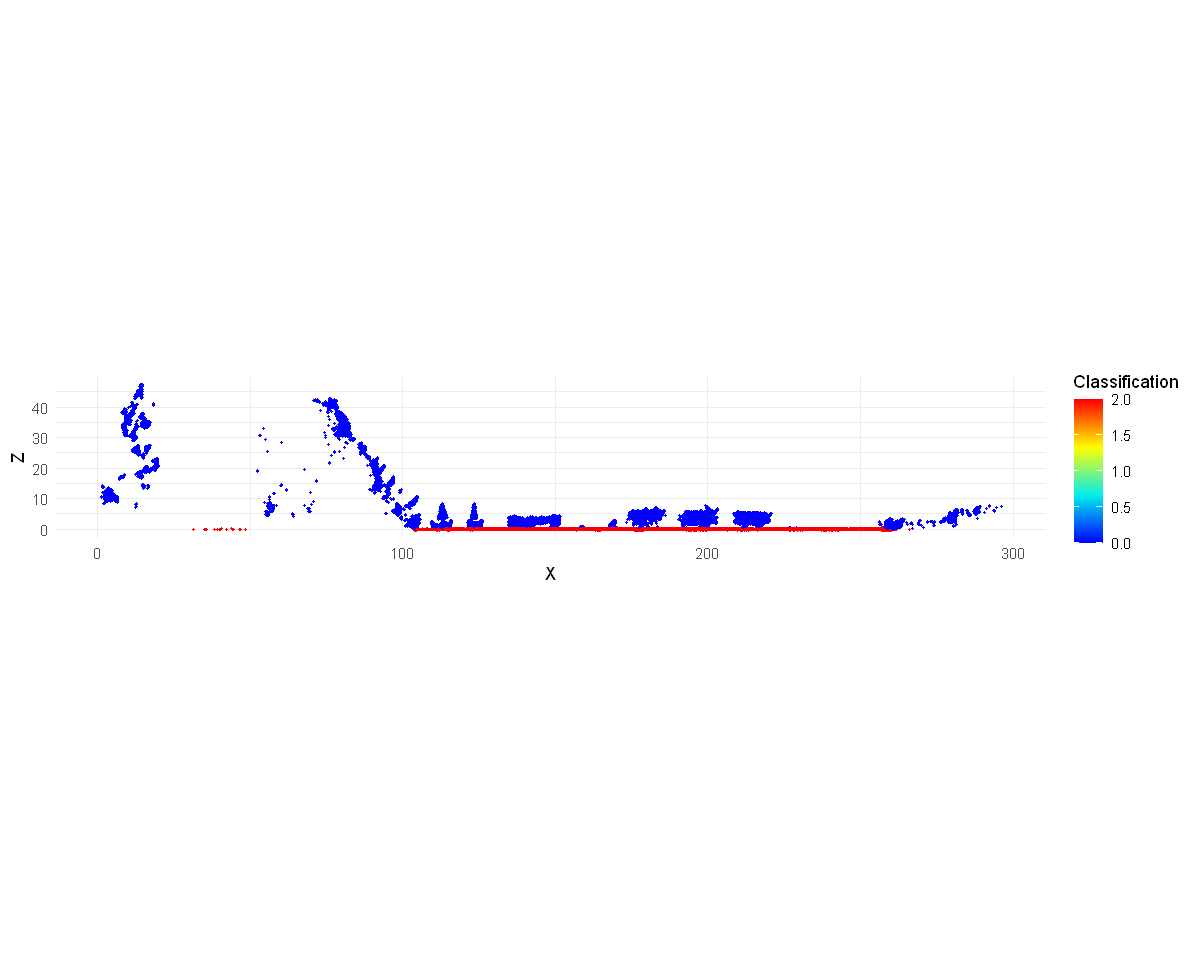

In [97]:
ggplot(payload(las_tr), aes(X,Z, color = Classification)) + 
  geom_point(size = 0.5) + 
  coord_equal() + 
  theme_minimal() +
  scale_color_gradientn(colours = height.colors(50))

# Filter grapes by colour

In [111]:
las_riesling <- filter_poi(las_filtered, 
                           R > 120 & 
                           G > 70 & 
                           B < 100 & 
                           G > R)

## Noise classificaiton

In [147]:
noise_classified <- classify_noise(las_riesling, ivf(1, 20))

In [148]:
# Step 4: Save the filtered point cloud
writeLAS(noise_classified, "grape_clusters3.las")

In [ ]:
noise.removal <- function(las.file, grape.type, grid.res, ridgedness){
    density_raster <- grid_density(las.file, res = grid.res)
    overall_avg_density <- mean(values(density_raster), na.rm = TRUE)

    thinned <- decimate_points(riesling, homogenize(overall_avg_density, res = 1, use_pulse = FALSE))

    csf_params <- csf(
      class_threshold = 0.5,  
      cloth_resolution = 1.0,  
      rigidness = ridgedness,          
      time_step = 0.65,        
      iterations = 1000       
    )

    las_ground <- classify_ground(thinned, csf_params)

    dem <- rasterize_terrain(las_ground, res = 1, algorithm = tin())

    las_norm <- normalize_height(las_ground, dem)#use_class = las_ground@data$Classification, algorithm = tin()) 


    # TODO: Add 
    las_filtered <- filter_poi(las_norm, 
                               Classification ==0 & 
                               Z >= 3 & 
                               Z <= 7 
                               R > 120 & 
                               G > 70 & 
                               B < 100 & 
                               G > R
                              )
    
}